# Градиентный спуск и линейные модели

[Линейные модели](https://ru.wikipedia.org/wiki/%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F) являются наиболее простыми моделями, используемыми в машинном обучении.

Традиционно этот класс моделей в большей степени используется для решения задач регрессии.

Детально описаны в библиотеке [scikit-learn.](https://scikit-learn.org/stable/modules/linear_model.html)

Линейные модели активно используются в [рекомендуемых методах scikit-learn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) для регрессии.


In [1]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from scipy.optimize import fmin_tnc
from IPython.display import Image
from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Основы метода

В основе метода лежит гипотеза, что целевой признак $y$ линейно зависит от матрицы исходных признаков $X$ ($k$ - количество признаков): $y \sim X$.

Тогда значение целевого признака $y$ можно аппроксимировать с помощью линейной функции $f(x,b)$:

$$ y = f(x,b) + \epsilon$$
$$ \hat{y} = f(x,b) $$
$$ y = \hat{y} + \epsilon$$
где:
- $y$ - истинное значение целевого признака
- $\hat{y}$ - предсказанное значение целевого признака
- $\epsilon$ - ошибка модели


Ошибка всегда присутствует, ведь на практике нет никакой гарантии, что зависимость между исходными признаками и целевым признаком действительно линейная.

В модели линейной регресии $\hat{y} = f(x,b)$ можно представить как скалярное произведение вектора признаков (регрессоров или факторов) $x_i$ на вектор коэффициентов модели $b_i$:

$$ \hat{y} = f(x,b) = b_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n $$

Коэффициент $b_0$ (константу) можно рассматривать как коэффициент при нулевом признаке, который всегда равен 1 ($x_0=1$). Тогда:

$$ \hat{y} = f(x,b) = b_0 \cdot x_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n = \sum\limits_{j=0}^N b_j \cdot x_j = x^T b $$

Построение модели линейной регресии означает нахождение всех коэффициентов $b_i$ на основании известных значений матрицы исходных признаков $X$ и вектора целевого признака $y$ из обучающей выборки.

Фактически, нужно найти такие значения $b_i$, которые минимизируют ошибку $\epsilon$.

Значение коэффициентов $b_i$ может быть найдено:
1. аналитически
1. с использованием численных методов (что используется на практике наиболее часто)




Для удобства демонстрации метода рассмотрим частный случай с единственным регрессором: 
$$ y = \hat{y} + \epsilon$$
$$ \hat{y} = b_0 + b_1 \cdot x_1 $$

### Подготовка данных

В качестве набора данных будем использовать Boston dataset.

In [2]:
boston = load_boston()

In [3]:
df_boston = pd.DataFrame(boston.data,columns=boston.feature_names)
df_boston['target'] = pd.Series(boston.target)
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


<AxesSubplot:>

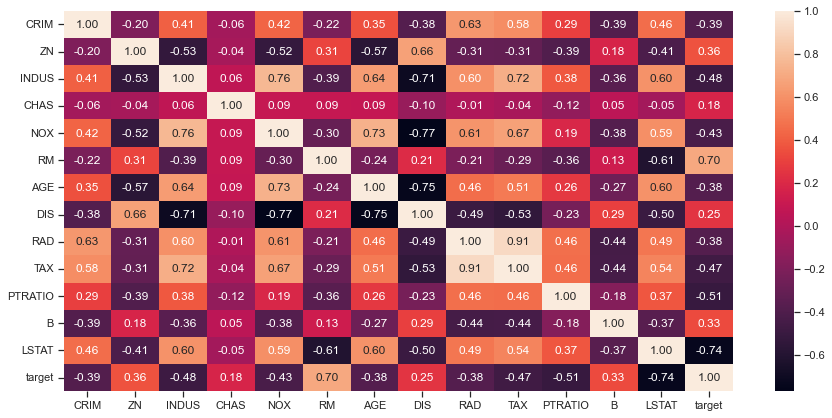

In [4]:
#Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(df_boston.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

<AxesSubplot:xlabel='RM', ylabel='target'>

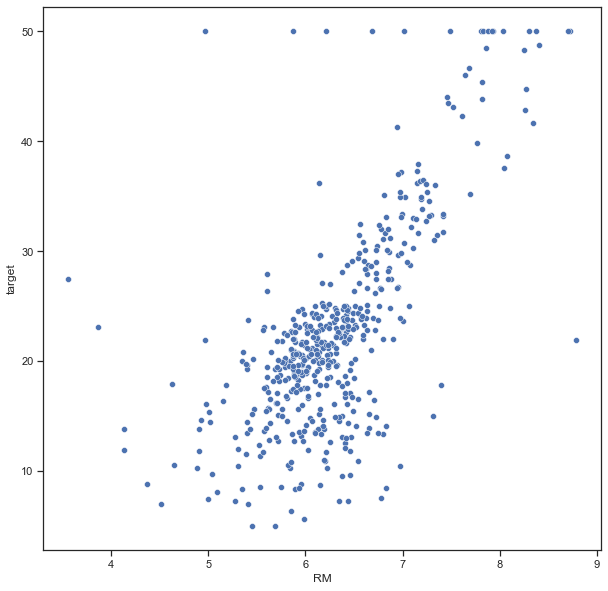

In [5]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.scatterplot(ax=ax, x='RM', y='target', data=df_boston)

Между признаком "RM" и целевым признаком "target" существует зависимость, близкая к линейной, коэффициент корреляции = 0,7

Попробуем восстановить данную линейную зависимость.

## Аналитическое восстановление зависимости

Для аналитического восстановления зависимости можно использовать следующие формулы (которые выводятся на основе рассматриваемого далее метода наименьших квадратов).

Пусть $\overline{x}$ - среднее значение для x, а $\overline{y}$ - среднее значение для y.

Тогда для средних значений рассматриваемой выборки:

$$ \overline{y} = b_0 + b_1 \overline{x} $$

Примем без вывода что:

$$ b_1 = \frac{\frac{1}{k} \cdot \sum\limits_{i=1}^k (x_i - \overline{x}) \cdot (y_i - \overline{y})}{\frac{1}{k} \cdot \sum\limits_{i=1}^k (x_i - \overline{x})^2} = \frac{Cov(x,y)}{Var(x)} $$

где:
- Cov(x,y) - [ковариация](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%B2%D0%B0%D1%80%D0%B8%D0%B0%D1%86%D0%B8%D1%8F) между величинами x,y.
- Var(x) - [дисперсия](https://ru.wikipedia.org/wiki/%D0%94%D0%B8%D1%81%D0%BF%D0%B5%D1%80%D1%81%D0%B8%D1%8F_%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D0%BE%D0%B9_%D0%B2%D0%B5%D0%BB%D0%B8%D1%87%D0%B8%D0%BD%D1%8B) x.

Тогда:

$$ b_0 = \overline{y} - b_1 \overline{x} $$

Вывод приведен [здесь.](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BD%D0%B0%D0%B8%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%BE%D0%B2#%D0%9C%D0%9D%D0%9A_%D0%B2_%D1%81%D0%BB%D1%83%D1%87%D0%B0%D0%B5_%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%BE%D0%B9_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8)

In [6]:
# Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray, 
                       y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-y_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [7]:
x_array = df_boston['RM'].values
y_array = df_boston['target'].values

In [8]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(-34.67062077643857, 9.10210898118031)

**Аналитически вычисленные коэффициенты b0, b1 будут использоваться в дальнейшем для сравнения с другими моделями.**

In [9]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

In [10]:
y_array_regr = y_regr(x_array, b0, b1)

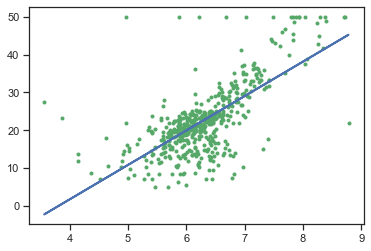

In [11]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

## Восстановление зависимости с использованием численных методов

Смысл использования всех численных методов сводится к тому, чтобы в выражении $y = \hat{y} + \epsilon$ минимизировать ошибку $\epsilon \rightarrow min$ (или какой-либо функцию от ошибки, называемую функцией потерь - $L$), то есть насколько это возможно приблизить предсказанные значения $\hat{y}$ к действительным значениям $y$.

Одним из наиболее часто используемых методов является метод наименьших квадратов.

### [Метод наименьших квадратов](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BD%D0%B0%D0%B8%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D0%B4%D1%80%D0%B0%D1%82%D0%BE%D0%B2)

В методе наименьших квадратов в качестве функции потерь используется квадрат ошибки $\epsilon^2$.

Решается задача оптимизации:

$$ L = \epsilon^2 \rightarrow min = \sum\limits_{i=1}^k \epsilon_i^2 \rightarrow min = \sum\limits_{i=1}^k (y_i - \hat{y}_i)^2 \rightarrow min $$

Проиллюстрируем метод наименьших квадратов. Для первых K=10 точек покажем ошибки между истинными и предсказанными значениями:

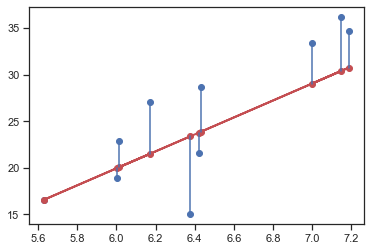

In [12]:
# Синими отрезками показаны ошибки между 
# истинными и предсказанными значениями
K_mnk=10

plt.plot(x_array[1:K_mnk+1], y_array[1:K_mnk+1], 'bo')
plt.plot(x_array[1:K_mnk+1], y_array_regr[1:K_mnk+1], '-ro', linewidth=2.0)

for i in range(len(x_array[1:K_mnk+1])):
    x1 = x_array[1:K_mnk+1][i]
    y1 = y_array[1:K_mnk+1][i]
    y2 = y_array_regr[1:K_mnk+1][i]
    plt.plot([x1,x1],[y1,y2],'b-')

plt.show()

Использование метода наименьших квадратов предполагает решение задачи оптимизации одним из методов оптимизации. Одним из наиболее часто используемых методов является: 

## [Градиентный спуск](https://ru.wikipedia.org/wiki/%D0%93%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA) или метод наискорейшего спуска

Обычно в градиентном спуске рассматривается следующая функция потерь:

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - \hat{y}_i)^2$$

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - (b_1 \cdot x_i + b_0))^2$$

Найдем частные производные функции потерь по коэффициентам регресии:

$$ \frac{\partial L}{\partial b_1} = 
\frac{1}{k} \cdot \sum\limits_{i=1}^k 2 \cdot (y_i - (b_1 \cdot x_i + b_0)) \cdot (-x_i) =
\frac{-2}{k} \cdot \sum\limits_{i=1}^k x_i \cdot (y_i - \hat{y_i})  $$

$$ \frac{\partial L}{\partial b_0} = 
\frac{1}{k} \cdot \sum\limits_{i=1}^k 2 \cdot (y_i - (b_1 \cdot x_i + b_0)) \cdot (-1) =
\frac{-2}{k} \cdot \sum\limits_{i=1}^k (y_i - \hat{y_i})  $$


Будем двигаться с шагом $\lambda$ (learning rate) в направлении антиградиента, выполняя в цикле следующие действия:

$$ b_0 = b_0 - \lambda \cdot \frac{\partial L}{\partial b_0} $$

$$ b_1 = b_1 - \lambda \cdot \frac{\partial L}{\partial b_1} $$

Могут рассматриваться различные критерии остановки цикла. Наиболее простым критерием является сходимость значений коэффициентов - модуль разности между значениями коэффициентов на $i$ и $i-1$ шагах не превышает определенного порога $\epsilon^b$: $|b^i - b^{i-1}| < \epsilon^b$.

В простейшей реализации гиперпараметром алгоритма может являться фиксированное количество эпох.

In [13]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                     y_array : np.ndarray,
                     b0_0 : float,
                     b1_0 : float,
                     epochs : int,
                     learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs): 
        # Вычисление новых предсказанных значений
        # используется векторизованное умножение и сложение для вектора и константы
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        # np.multiply - поэлементное умножение векторов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred
    

In [14]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print('b0 = {} - (теоретический), {} - (градиентный спуск)'.format(b0, grad_b0))
    print('b1 = {} - (теоретический), {} - (градиентный спуск)'.format(b1, grad_b1))
    print('MSE = {}'.format(mean_squared_error(y_array_regr, grad_y_pred)))
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

b0 = -34.67062077643857 - (теоретический), 0.31351829572408224 - (градиентный спуск)
b1 = 9.10210898118031 - (теоретический), 2.0495443998606735 - (градиентный спуск)
MSE = 111.71640241050893


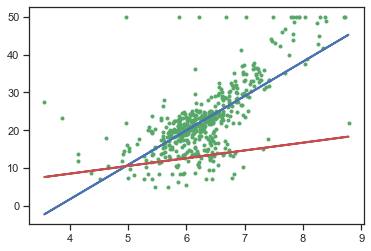

In [15]:
# Примеры использования градиентного спуска
show_gradient_descent(10, 0, 0)

b0 = -34.67062077643857 - (теоретический), -0.27688616098409397 - (градиентный спуск)
b1 = 9.10210898118031 - (теоретический), 3.6952395341558737 - (градиентный спуск)
MSE = 14.574581642017632


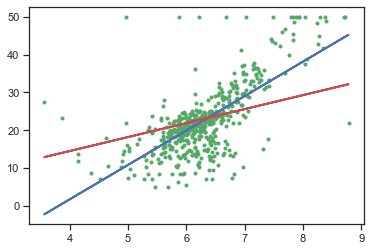

In [16]:
show_gradient_descent(1000, 0, 0)

b0 = -34.67062077643857 - (теоретический), -24.08447488109039 - (градиентный спуск)
b1 = 9.10210898118031 - (теоретический), 7.437913177983587 - (градиентный спуск)
MSE = 1.3807440347460191


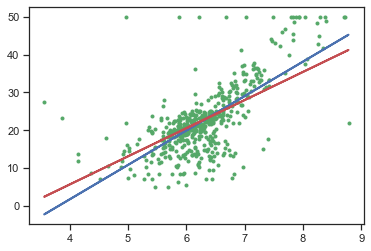

Wall time: 2.15 s


In [17]:
%%time
show_gradient_descent(50000, 0, 0)

b0 = -34.67062077643857 - (теоретический), -31.48970103927921 - (градиентный спуск)
b1 = 9.10210898118031 - (теоретический), 8.602052272230887 - (градиентный спуск)
MSE = 0.12466451371777229


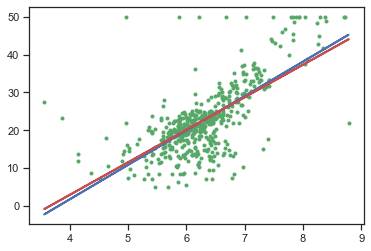

Wall time: 3.86 s


In [18]:
%%time
show_gradient_descent(100000, 0, 0)

b0 = -34.67062077643857 - (теоретический), -34.670620775166505 - (градиентный спуск)
b1 = 9.10210898118031 - (теоретический), 9.10210898098034 - (градиентный спуск)
MSE = 1.993672872804036e-20


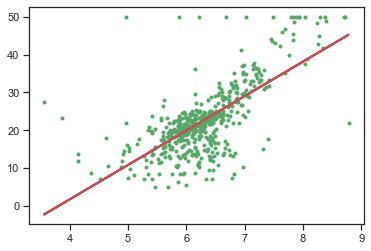

Wall time: 39.5 s


In [19]:
%%time
show_gradient_descent(1000000, 0, 0)

b0 = -34.67062077643857 - (теоретический), -29.60657729498942 - (градиентный спуск)
b1 = 9.10210898118031 - (теоретический), 8.306015672780253 - (градиентный спуск)
MSE = 0.3159601254498195


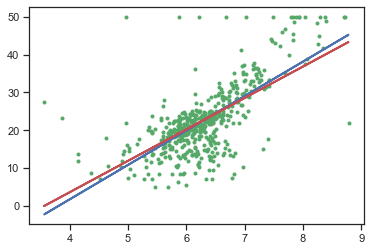

In [20]:
# Сходимость алгоритма может сильно зависеть от начальных значений
show_gradient_descent(1000, -30, 5)

b0 = -34.67062077643857 - (теоретический), -34.202270478337226 - (градиентный спуск)
b1 = 9.10210898118031 - (теоретический), 9.028481939929286 - (градиентный спуск)
MSE = 0.002702582918731034


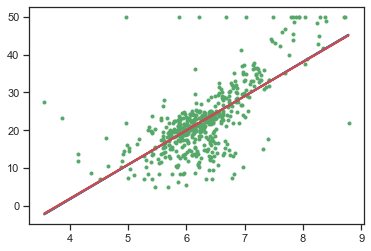

In [21]:
show_gradient_descent(100000, -30, 5)

### Использование класса [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) библиотеки scikit-learn.

In [22]:
# Обучим линейную регрессию и сравним коэффициенты с рассчитанными ранее
reg1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))
(b1, reg1.coef_), (b0, reg1.intercept_)

((9.10210898118031, array([[9.10210898]])),
 (-34.67062077643857, array([-34.67062078])))

### [Стохастический градиентный спуск](http://www.machinelearning.ru/wiki/index.php?title=%D0%A1%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D1%8B%D0%B9_%D1%81%D0%BF%D1%83%D1%81%D0%BA)

Пердполагает, что обучение на каждом шаге (эпохе) происходит не на полном наборе данных а на одном случайно выбранном примере. В случае большой обучающей выборки такой подход может многократно ускорить обучение.

В соответствии с [рекомендуемыми методами scikit-learn](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) стохастический градиентный спуск рекомендуется использовать для задачи регрессии, если размер выборки превышает 100 000 записей.

В библиотеке scikit-learn используются классы:
- [SGDRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html) для регрессии.
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) для классификации.

In [23]:
# Для небольшой выборки качество обучения сильно уступает нестохастическому градиентному спуску.
print('Размер выборки - {}'.format(x_array.shape[0]))
reg2 = SGDRegressor().fit(x_array.reshape(-1, 1), y_array)
(b1, reg2.coef_), (b0, reg2.intercept_)

Размер выборки - 506


((9.10210898118031, array([4.97577344])),
 (-34.67062077643857, array([-5.63524331])))

## Использование регуляризации в линейных моделях

[Регуляризация](https://ru.wikipedia.org/wiki/%D0%A0%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_(%D0%BC%D0%B0%D1%82%D0%B5%D0%BC%D0%B0%D1%82%D0%B8%D0%BA%D0%B0) ) - Это метод, который используется для борьбы с переобучением и улучшения качества моделей.

Известно, что для переобученных моделей характерны большие значения коэффициентов $b_j$. Смысл регуляризации состоит в том, чтобы к функции потерь добавить "штраф" за большие значения коэффициентов. При оптимизации такой функции переобучение становится менее вероятным.

Задача оптимизации (без регуляризации):

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - \hat{y}_i)^2 \rightarrow min$$

Коэффициент $b_0$ (константу) можно рассматривать как коэффициент при нулевом признаке, который всегда равен 1 ($x_0=1$). Тогда:

$$ \hat{y} = f(x,b) = b_0 \cdot x_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n = \sum\limits_{j=0}^N b_j \cdot x_j $$

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - \sum\limits_{j=0}^N b_j \cdot x_{ij})^2 \rightarrow min$$

#### 1) $L_2$ регуляризация или гребневая регрессия (Ridge Regression) или [регуляризация Тихонова](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D1%80%D0%B5%D0%B3%D1%83%D0%BB%D1%8F%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8_%D0%A2%D0%B8%D1%85%D0%BE%D0%BD%D0%BE%D0%B2%D0%B0)

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - \sum\limits_{j=0}^N b_j \cdot x_{ij})^2 + \alpha \cdot \sum\limits_{j=0}^N (b_j)^2 \rightarrow min$$

где $\alpha$ - константа регуляризации.

В библиотеке scikit-learn используются класс [Ridge.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

#### 2) $L_1$ регуляризация или [LASSO-регрессия](https://en.wikipedia.org/wiki/Lasso_(statistics))

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - \sum\limits_{j=0}^N b_j \cdot x_{ij})^2 + \alpha \cdot \sum\limits_{j=0}^N |b_j| \rightarrow min$$

Основная особенность этого метода состоит в том, что коэффициенты $b_j$ близкие к нулю становятся нулевыми. Происходит автоматическое удаление наименее значимых признаков.

В библиотеке scikit-learn используются класс [Lasso.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

#### 3) Elastic net

Наиболее общим методом является [Elastic net](https://en.wikipedia.org/wiki/Elastic_net_regularization), который обощает $L_1$ и $L_2$ регуляризацию.

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - \sum\limits_{j=0}^N b_j \cdot x_{ij})^2 + \bigg( \alpha_1 \cdot \sum\limits_{j=0}^N |b_j| + \alpha_2 \cdot \sum\limits_{j=0}^N (b_j)^2 \bigg) \rightarrow min$$

Коэффициенты $\alpha_1$ и $\alpha_2$ принято представлять в виде:

$$ \alpha = \alpha_1 + \alpha_2 $$

$$ L1Ratio = \frac{\alpha_1}{\alpha_1 + \alpha_2} $$

Тогда:

$$ L = \frac{1}{k} \cdot \sum\limits_{i=1}^k (y_i - \sum\limits_{j=0}^N b_j \cdot x_{ij})^2 + \alpha \cdot \bigg( L1Ratio \cdot \sum\limits_{j=0}^N |b_j| + \frac{1-L1Ratio}{2} \cdot \sum\limits_{j=0}^N (b_j)^2 \bigg) \rightarrow min$$

При L1Ratio=1 получается $L_1$ - регуляризация. При L1Ratio=0 получается $L_2$ - регуляризация.


В библиотеке scikit-learn используются класс [ElasticNet.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html)


In [24]:
from sklearn.linear_model import Lasso

In [25]:
reg3 = Lasso().fit(x_array.reshape(-1, 1), y_array)
(b1, reg3.coef_), (b0, reg3.intercept_)

((9.10210898118031, array([7.07245664])),
 (-34.67062077643857, -21.91499786473452))

In [26]:
from sklearn.linear_model import Ridge

In [27]:
reg4 = Ridge().fit(x_array.reshape(-1, 1), y_array)
(b1, reg4.coef_), (b0, reg4.intercept_)

((9.10210898118031, array([9.06574473])),
 (-34.67062077643857, -34.44208476612967))

In [28]:
from sklearn.linear_model import ElasticNet

In [29]:
reg5 = ElasticNet().fit(x_array.reshape(-1, 1), y_array)
(b1, reg5.coef_), (b0, reg5.intercept_)

((9.10210898118031, array([4.01388612])),
 (-34.67062077643857, -2.6930004271520183))

## [Нелинейная регрессия](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D0%BB%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F)

Используется в том случае, когда данные аппроксимируются моделью, которая является более сложной, чем линейная.

В библиотеке scikit-learn реализован класс [PolynomialFeatures](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) для [полиномиальной регрессии.](http://www.machinelearning.ru/wiki/index.php?title=%D0%9B%D0%B8%D0%BD%D0%B5%D0%B9%D0%BD%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F)

Необходимо отметить, что возведение признака в степень или произведение признаков не является линейным преобразованием признаков и не может отрицательно повлиять на качество модели.

Для комбинации классов используются [конвейры (pipeline).](https://scikit-learn.org/stable/modules/compose.html#pipeline)

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [31]:
poly_model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                       ('linear', LinearRegression(fit_intercept=False))])

In [32]:
poly_model.fit(x_array.reshape(-1, 1), y_array)

Pipeline(steps=[('poly', PolynomialFeatures(degree=3)),
                ('linear', LinearRegression(fit_intercept=False))])

In [33]:
poly_y_pred = poly_model.predict(x_array.reshape(-1, 1))

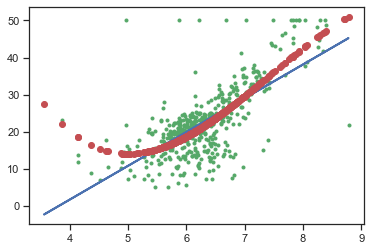

In [34]:
plt.plot(x_array, y_array, 'g.')
plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.plot(x_array, poly_y_pred, 'ro')
plt.show()

In [35]:
# Степени полинома
poly_model.named_steps['linear'].coef_, poly_model.named_steps['linear'].intercept_

(array([ 241.31081379, -109.39060642,   16.49101629,   -0.74039372]), 0.0)

In [36]:
def test_poly_model(degree=3):
    poly_model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                       ('linear', LinearRegression(fit_intercept=False))])
    poly_model.fit(x_array.reshape(-1, 1), y_array)
    poly_y_pred = poly_model.predict(x_array.reshape(-1, 1))
    
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, poly_y_pred, 'ro')
    plt.show()
    
    print('Степени полинома - {}'.format(poly_model.named_steps['linear'].coef_))

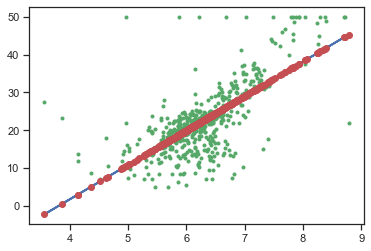

Степени полинома - [-34.67062078   9.10210898]


In [37]:
test_poly_model(degree=1)

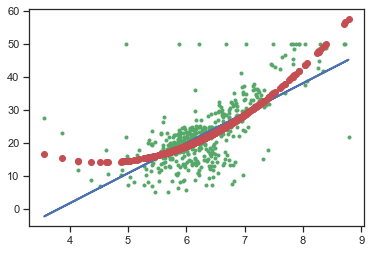

Степени полинома - [ 66.05884748 -22.64326237   2.47012384]


In [38]:
test_poly_model(degree=2)

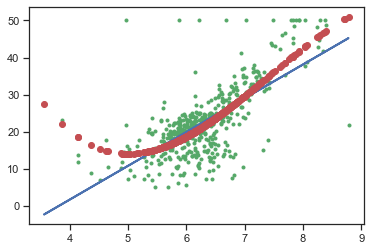

Степени полинома - [ 241.31081379 -109.39060642   16.49101629   -0.74039372]


In [39]:
test_poly_model(degree=3)

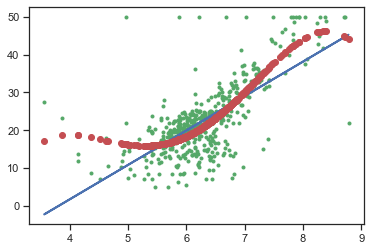

Степени полинома - [-463.48272953  371.4567309  -103.65855356   12.32148784   -0.52209014]


In [40]:
test_poly_model(degree=4)

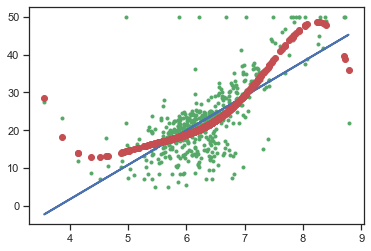

Степени полинома - [ 3.17350044e+03 -2.76788936e+03  9.57791192e+02 -1.63717675e+02
  1.38185728e+01 -4.59569815e-01]


In [41]:
test_poly_model(degree=5)

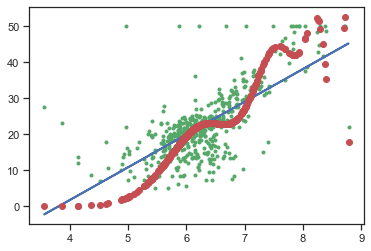

Степени полинома - [ 2.19795311e-18  7.49025103e-18  3.25722232e-19 -7.84345104e-20
 -6.58185393e-21  1.01776914e-20 -2.61266203e-21 -2.44437762e-21
  2.96681056e-28  1.53382348e-27  7.86167302e-27  3.98841922e-26
  1.99923375e-25  9.88184185e-25  4.80545422e-24  2.29300361e-23
  1.07027439e-22  4.86838419e-22  2.14832579e-21  9.14517085e-21
  3.72867211e-20  1.44260236e-19  5.23050548e-19  1.74646762e-18
  5.23364088e-18  1.35088191e-17  2.78839833e-17  3.88416292e-17
  1.65340554e-17 -3.77639869e-17  1.76588498e-17 -4.09842817e-18
  5.47756492e-19 -4.30466170e-20  1.85742166e-21 -3.40857113e-23]


In [42]:
test_poly_model(degree=35)

## [Логистическая регрессия](https://ru.wikipedia.org/wiki/%D0%9B%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D1%8F) 

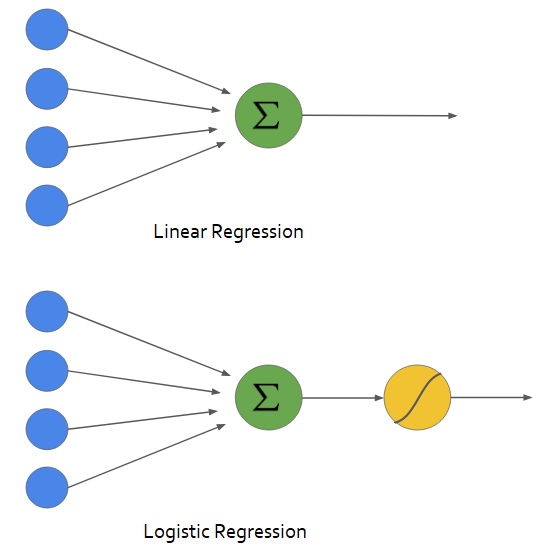

In [43]:
# Источник - https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24
Image('img/lr.png', width='50%')

Не смотря на присутствие слова "регрессия" в названии метода, данный метод используется для решения задачи бинарной классификации.

Метод основан на использовании [логистической кривой или сигмоиды:](https://ru.wikipedia.org/wiki/%D0%A1%D0%B8%D0%B3%D0%BC%D0%BE%D0%B8%D0%B4%D0%B0)

$$f(x)=\frac{1}{1+e^{-x}}$$

In [44]:
# Определение функции
# f(0)=0.5
x = np.linspace(-7, 7, 31)
y = 1 / (1 + np.exp(-x))
list(zip(x,y))

[(-7.0, 0.0009110511944006454),
 (-6.533333333333333, 0.0014520391100099122),
 (-6.066666666666666, 0.0023135251651203942),
 (-5.6, 0.003684239899435989),
 (-5.133333333333333, 0.005862302196338335),
 (-4.666666666666666, 0.009315959345066693),
 (-4.2, 0.014774031693273055),
 (-3.7333333333333334, 0.023354516476977092),
 (-3.2666666666666666, 0.03673259067202974),
 (-2.8, 0.057324175898868755),
 (-2.333333333333333, 0.08839967720705845),
 (-1.8666666666666663, 0.1339278883240737),
 (-1.4000000000000004, 0.1978161114414182),
 (-0.9333333333333336, 0.28224894304225995),
 (-0.4666666666666668, 0.3854055017324505),
 (0.0, 0.5),
 (0.4666666666666668, 0.6145944982675495),
 (0.9333333333333336, 0.71775105695774),
 (1.4000000000000004, 0.8021838885585818),
 (1.8666666666666671, 0.8660721116759263),
 (2.333333333333334, 0.9116003227929417),
 (2.8000000000000007, 0.9426758241011313),
 (3.2666666666666675, 0.9632674093279703),
 (3.7333333333333343, 0.9766454835230229),
 (4.199999999999999, 0.9852

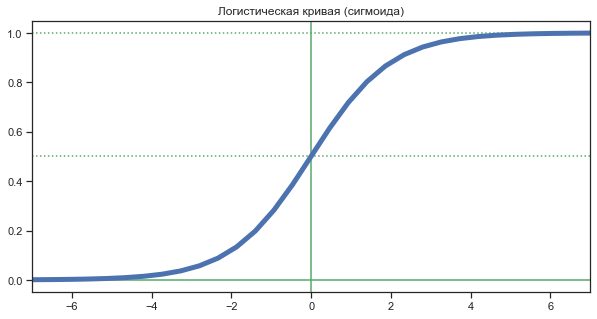

In [45]:
# Вывод графика и осей
plt.figure(figsize=(10, 5))
plt.plot([-7, 7], [0, 0], "g-")
plt.plot([-7, 7], [0.5, 0.5], "g:")
plt.plot([-7, 7], [1, 1], "g:")
plt.plot([0, 0], [-1.1, 1.1], "g-")
plt.plot(x, y, "b-", linewidth=5)
plt.axis([-7, 7, -0.05, 1.05])
plt.title('Логистическая кривая (сигмоида)')
plt.show() 

Модель линейной регрессии 

$$ z(x) = f(x,b) = b_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n$$

(диапазон $z(x) \in (- \infty, \infty)$)

может быть использована как параметр сигмоиды:

$$h(z)=\frac{1}{1+e^{-z}}$$

(диапазон $ h(z) \in (0, 1)$)

Таким образом, $h(z)$ можно рассматривать как вероятность принадлежности объекта $x_i$ к единичному классу. Вероятность принадлежности объекта $x_i$ к нулевому классу $1-h(z)$.

Подставляя параметр $z(x)$ в функцию $h(x)=h(z(x))$ получаем:

$$h(x)=\frac{1}{1+e^{-(b_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n)}}$$

Используем следующую функцию потерь:

$$ cost = \left \{
\begin{array}{>{\displaystyle\tallstrut}l@{}}
-ln(h(x)), y=1 
\\
-ln(1-h(x)), y=0
\end{array}
\right.
$$

Такой вид функции используется для того, чтобы создать максимально сильный штраф при несопадении истинного и предсказанного классов.

Комбинируя оба условия получаем:

$$cost(h(x),y)= -y \cdot ln(h(x)) - (1-y) \cdot ln(1-h(x))$$

Формируем полную функцию потерь (параметры $b$ неявно входят в $h(x_i)$):

$$ L(b) = - \frac{1}{k} \cdot \sum\limits_{i=1}^k 
\Big(
y_i \cdot ln(h(x_i)) + (1-y_i) \cdot ln(1-h(x_i))
\Big) = $$

$$ L(b) = - \frac{1}{k} \cdot \sum\limits_{i=1}^k 
\Big(
y_i \cdot ln \Big( \frac{1}{1+e^{-(b_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n)}}\Big) + (1-y_i) \cdot ln \Big( 1-\frac{1}{1+e^{-(b_0 + b_1 \cdot x_1 + \dots + b_n \cdot x_n )}}\Big)
\Big) $$

Частные производные полной функции потерь по коэффициентам регресии $b^j$:

$$ \frac{\partial L}{\partial b^j} = 
\frac{1}{k} \cdot \sum\limits_{i=1}^k 
(h(x_i) - y_i) \cdot x_i^j
$$

Детальное описание вывода производной приведено [в статье](https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d).

Если набор данных состоит из двух признаков, то он может быть визуализирован на плоскости.

В этом случае граничное условие:

$$b_0 + b_1 \cdot x_1 + b_2 \cdot x_2 = 0$$

Тогда:

$$x_2 = - \frac{b_0 + b_1 \cdot x_1}{b_2}$$


Реализуем градиентный спуск для логистической регресии.

In [46]:
# Подготовка данных
iris = load_iris()
iris_x_ds = pd.DataFrame(data=iris['data'], columns=iris['feature_names'])
iris_x_ds_lr = iris_x_ds[['petal length (cm)', 'sepal length (cm)']]
iris_x_ds_lr['x0'] = 1
iris_x_ds_lr['target'] = iris.target
iris_x_ds_lr.head()

C:\Users\Paladin\AppData\Local\Temp/ipykernel_16140/732040999.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iris_x_ds_lr['x0'] = 1


,petal length (cm),sepal length (cm),x0,target
0,1.4,5.1,1,0
1,1.4,4.9,1,0
2,1.3,4.7,1,0
3,1.5,4.6,1,0
4,1.4,5.0,1,0


In [47]:
def convert_target_to_binary(array:np.ndarray, target:int) -> np.ndarray:
    # Если целевой признак совпадает с указанным, то 1 иначе 0
    res = [1 if x==target else 0 for x in array]
    return res

In [48]:
bin_iris_y = convert_target_to_binary(iris.target, 0)

In [49]:
iris_x_ds_lr['target_bin'] = bin_iris_y
iris_x_ds_lr.head()

,petal length (cm),sepal length (cm),x0,target,target_bin
0,1.4,5.1,1,0,1
1,1.4,4.9,1,0,1
2,1.3,4.7,1,0,1
3,1.5,4.6,1,0,1
4,1.4,5.0,1,0,1


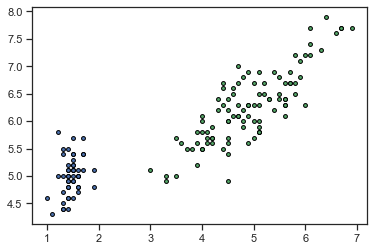

In [50]:
# Визуализация данных
colors = "gb"
#X_viz = iris.data[:, [1,2]]
X_viz = iris_x_ds_lr[['petal length (cm)', 'sepal length (cm)']].values
y_viz = iris_x_ds_lr['target_bin'].values
n_classes = len(np.unique(y_viz))
for i, color in zip(range(n_classes), colors):
    idx = np.where(y_viz == i)
    plt.scatter(X_viz[idx, 0], X_viz[idx, 1], 
                c=color, 
                cmap=plt.cm.RdYlBu, 
                edgecolor='black', s=15)
plt.show()    

In [51]:
# Реализация градиентного спуска
def sigmoid(x):
    '''
    Функция - сигмоида
    '''
    return 1 / (1 + np.exp(-x))

def proba(b, x):
    '''
    Вероятность единичного класса
    '''
    return sigmoid(np.dot(x,b))

def cost_function(b, x, y):
    '''
    Функция потерь
    '''
    k = x.shape[0]
    res = -(1 / k) * np.sum(
        y * np.log(proba(b, x)) 
        + (1 - y) * np.log(1 - proba(b, x)))
    return res

def gradient(b, x, y):
    '''
    Определение градиента
    '''
    k = x.shape[0]
    res = (1 / k) * np.dot(
        x.T, (proba(b, x) - y))

def optimize_lr(x, y, b):
    '''
    Для оптимизации используется функция 
    scipy.optimize.fmin_tnc
    '''
    opt_weights = fmin_tnc(
        func=cost_function, 
        x0=b,          
        fprime=gradient,
        approx_grad=True,
        args=(x, y))
    return opt_weights[0]    

In [52]:
opt_x = iris_x_ds_lr[['x0', 'petal length (cm)', 'sepal length (cm)']].values
opt_x[:5]

array([[1. , 1.4, 5.1],
       [1. , 1.4, 4.9],
       [1. , 1.3, 4.7],
       [1. , 1.5, 4.6],
       [1. , 1.4, 5. ]])

In [53]:
opt_y = iris_x_ds_lr['target_bin']
opt_y[:5]

0    1
1    1
2    1
3    1
4    1
Name: target_bin, dtype: int64

In [54]:
b_init = np.zeros(3)
b_init

array([0., 0., 0.])

In [55]:
b_res = optimize_lr(opt_x, opt_y, b_init)
b_res

array([ 19.20925943, -24.60629648,   7.8941256 ])

In [56]:
def vis_lr(b):
    '''
    Визуализация результата
    '''    
    colors = "gb"
    X_viz = iris_x_ds_lr[['petal length (cm)', 'sepal length (cm)']].values
    y_viz = iris_x_ds_lr['target_bin'].values
    n_classes = len(np.unique(y_viz))
    for i, color in zip(range(n_classes), colors):
        idx = np.where(y_viz == i)
        plt.scatter(X_viz[idx, 0], X_viz[idx, 1], 
                    c=color, 
                    cmap=plt.cm.RdYlBu, 
                    edgecolor='black', s=15)

    t1 = iris_x_ds_lr['petal length (cm)'].values    
    t2 = -((b[0]+np.dot(b[1], t1))/b[2])
    plt.plot(t1, t2, 'r', linewidth=2.0)   
    plt.show()    

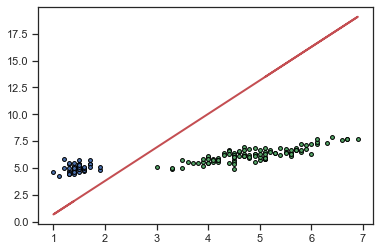

In [57]:
vis_lr(b_res)

### Реализация в sklearn

В sklearn для логистической регрессии используется класс [LogisticRegression.](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [58]:
from sklearn.linear_model import LogisticRegression

In [59]:
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(
    iris_x_ds_lr[['petal length (cm)', 'sepal length (cm)']].values, 
    iris_x_ds_lr['target_bin'].values, test_size=0.5, random_state=1)

In [60]:
cl1 = LogisticRegression()

In [61]:
cl1.fit(iris_X_train, iris_y_train)

LogisticRegression()

In [62]:
pred_iris_y_test = cl1.predict(iris_X_test)
pred_iris_y_test

array([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0], dtype=int64)

In [63]:
pred_iris_y_test_proba = cl1.predict_proba(iris_X_test)
pred_iris_y_test_proba[:10]

array([[3.03551669e-02, 9.69644833e-01],
       [6.61038870e-01, 3.38961130e-01],
       [9.91453895e-01, 8.54610520e-03],
       [3.26584185e-02, 9.67341582e-01],
       [9.99963965e-01, 3.60350727e-05],
       [9.95340342e-01, 4.65965828e-03],
       [9.98647747e-01, 1.35225325e-03],
       [1.15108534e-01, 8.84891466e-01],
       [4.98014444e-02, 9.50198556e-01],
       [9.99690875e-01, 3.09124539e-04]])

In [64]:
# Вероятность принадлежности к 0 классу
[round(x, 4) for x in pred_iris_y_test_proba[:10,0]]

[0.0304, 0.661, 0.9915, 0.0327, 1.0, 0.9953, 0.9986, 0.1151, 0.0498, 0.9997]

In [65]:
# Вероятность принадлежности к 1 классу
[round(x, 4) for x in pred_iris_y_test_proba[:10,1]]

[0.9696, 0.339, 0.0085, 0.9673, 0.0, 0.0047, 0.0014, 0.8849, 0.9502, 0.0003]

In [66]:
# Сумма вероятностей равна 1
pred_iris_y_test_proba[:10,0] + pred_iris_y_test_proba[:10,1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [67]:
accuracy_score(iris_y_test, pred_iris_y_test)

1.0

In [68]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [69]:
print_accuracy_score_for_classes(iris_y_test, pred_iris_y_test)

Метка 	 Accuracy
0 	 1.0
1 	 1.0


### Случай многоклассовой классификации

Класс LogisticRegression может быть использован для многоклассовой классификации. В этом случае для каждого класса создается отдельная модель логистической регресии, каждая модель обучается по схеме "один-против-остальных".

# Дополнительные источники
- https://habr.com/ru/company/io/blog/265007/
- https://habr.com/ru/post/307004/
- https://habr.com/ru/company/ods/blog/323890/
- https://towardsdatascience.com/building-a-logistic-regression-in-python-301d27367c24
- https://medium.com/analytics-vidhya/derivative-of-log-loss-function-for-logistic-regression-9b832f025c2d
